# HW1: Autoregressive Models
**Meng Linghui**  

mengreinhold@163.com

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn
import torch.utils.data
import math

## Exercise 1: Warmup

First, run the following code. It will generate a dataset of samples $x \in \{1,...,100\}.$

In [3]:
import numpy as np
def sample_data(seed=0, count=10000):
    rand = np.random.RandomState(seed)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [4]:
data = sample_data()

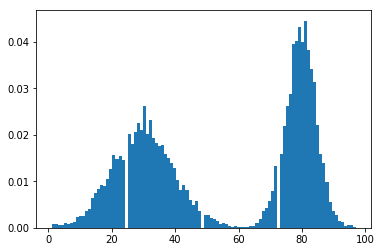

In [5]:
plt.hist(data, 100, density=True)
plt.show()

Take the ﬁrst 80% of the samples as a training set and the remaining 20% as a test set.

In [6]:
training_set = data[:int(len(data)*0.6)] 
val_set = data[int(len(data)*0.6):int(len(data)*0.8)]
test_set = data[int(len(data)*0.8):]

Let $\theta = (\theta_{1}, ..., \theta_{100}) \in \mathbb{R}^{100}$, and define the model

$$
p_{\theta}(x) = \frac{e^{\theta_{x}}}{\sum_{x'}{e^{\theta_{x'}}}}
$$

Fit $p_{\theta}$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

In [7]:
theta = torch.zeros(100, requires_grad=True)

In [8]:
def compute_loss(theta,x):
    #softmax
    _theta=torch.exp(theta) / torch.sum(torch.exp(theta))

    #instead of having a one hot encoded vector x, just use gather instead:
    prob = torch.gather(_theta, dim=0, index=x)

    loss = torch.sum(-torch.log2(prob))/prob.shape[0]
    return loss

Over the course of training, record the average negative log likelihood of the training data (per minibatch) and validation data (for your entire validation set). Plot both on the same graph &ndash; the x-axis should be training setps, and the y-axis should be negative log likelihood; feel free to compute and report the validation performance less frequently. Report the test set performance of your final model. Be sure to report all negative log likelihoods in bits.

## Create data and set parameters

In [9]:
batch_size = 512
optimizer = torch.optim.Adam([theta], lr=3e-4)
epochs=1000

Our model seems to have generally learned the distribution of the data. However, it failed to capture the masked values that do not appear in the true distribution ($p(x) = 0$).

Epoch 0: loss6.639858245849609 val_loss6.639645576477051 
Epoch 100: loss6.31960391998291 val_loss6.310617446899414 
Epoch 200: loss6.099104404449463 val_loss6.1118364334106445 
Epoch 300: loss5.957765102386475 val_loss5.9943108558654785 
Epoch 400: loss5.909001350402832 val_loss5.927659034729004 
Epoch 500: loss5.897202968597412 val_loss5.891689300537109 
Epoch 600: loss5.906694412231445 val_loss5.872215747833252 
Epoch 700: loss5.824578285217285 val_loss5.860999584197998 
Epoch 800: loss5.744894504547119 val_loss5.85427188873291 
Epoch 900: loss5.8693318367004395 val_loss5.850193977355957 


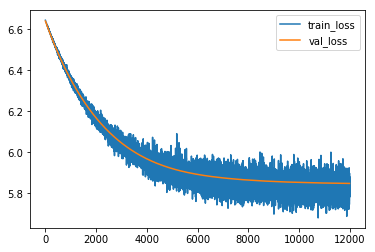

In [10]:
train_iter = torch.utils.data.DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
val_set_iter = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0

    for train_batch in train_iter:

        loss= compute_loss(theta,train_batch)

        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)

    with torch.set_grad_enabled(False):

        val_loss = compute_loss(theta,torch.from_numpy(val_set))
        val_losses.append(val_loss)
        
    if epoch % 100 ==0:
        print('Epoch {}: loss{} val_loss{} '.format(epoch,loss,val_loss))

import matplotlib.pyplot as plt
plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()

In [11]:
test_iter = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

# Compute Test Loss
for idx, test_batch in enumerate(test_iter):
    test_loss = compute_loss(theta, test_batch)

## Show the final losses

In [12]:
print("Final Training Loss:", losses[-1].item())
print("Final Validation Loss:", val_losses[-1].item())
print("Final Test Loss:", test_loss.item())

Final Training Loss: 5.878973960876465
Final Validation Loss: 5.847798824310303
Final Test Loss: 5.847163677215576


## Data distributions

Plot the model probabilities in a bar graph, which $\{1, ..., 100\}$ on the x-axis and a real number in $[0, 1]$ on the y-axis. Next, draw 1000 samples from your model, and plot their empirical frequencies on a new bar graph with the same axes. How do both compare visually to the data distribution?

In [13]:
p = torch.exp(theta)/torch.sum(torch.exp(theta))
p = p.detach().numpy()

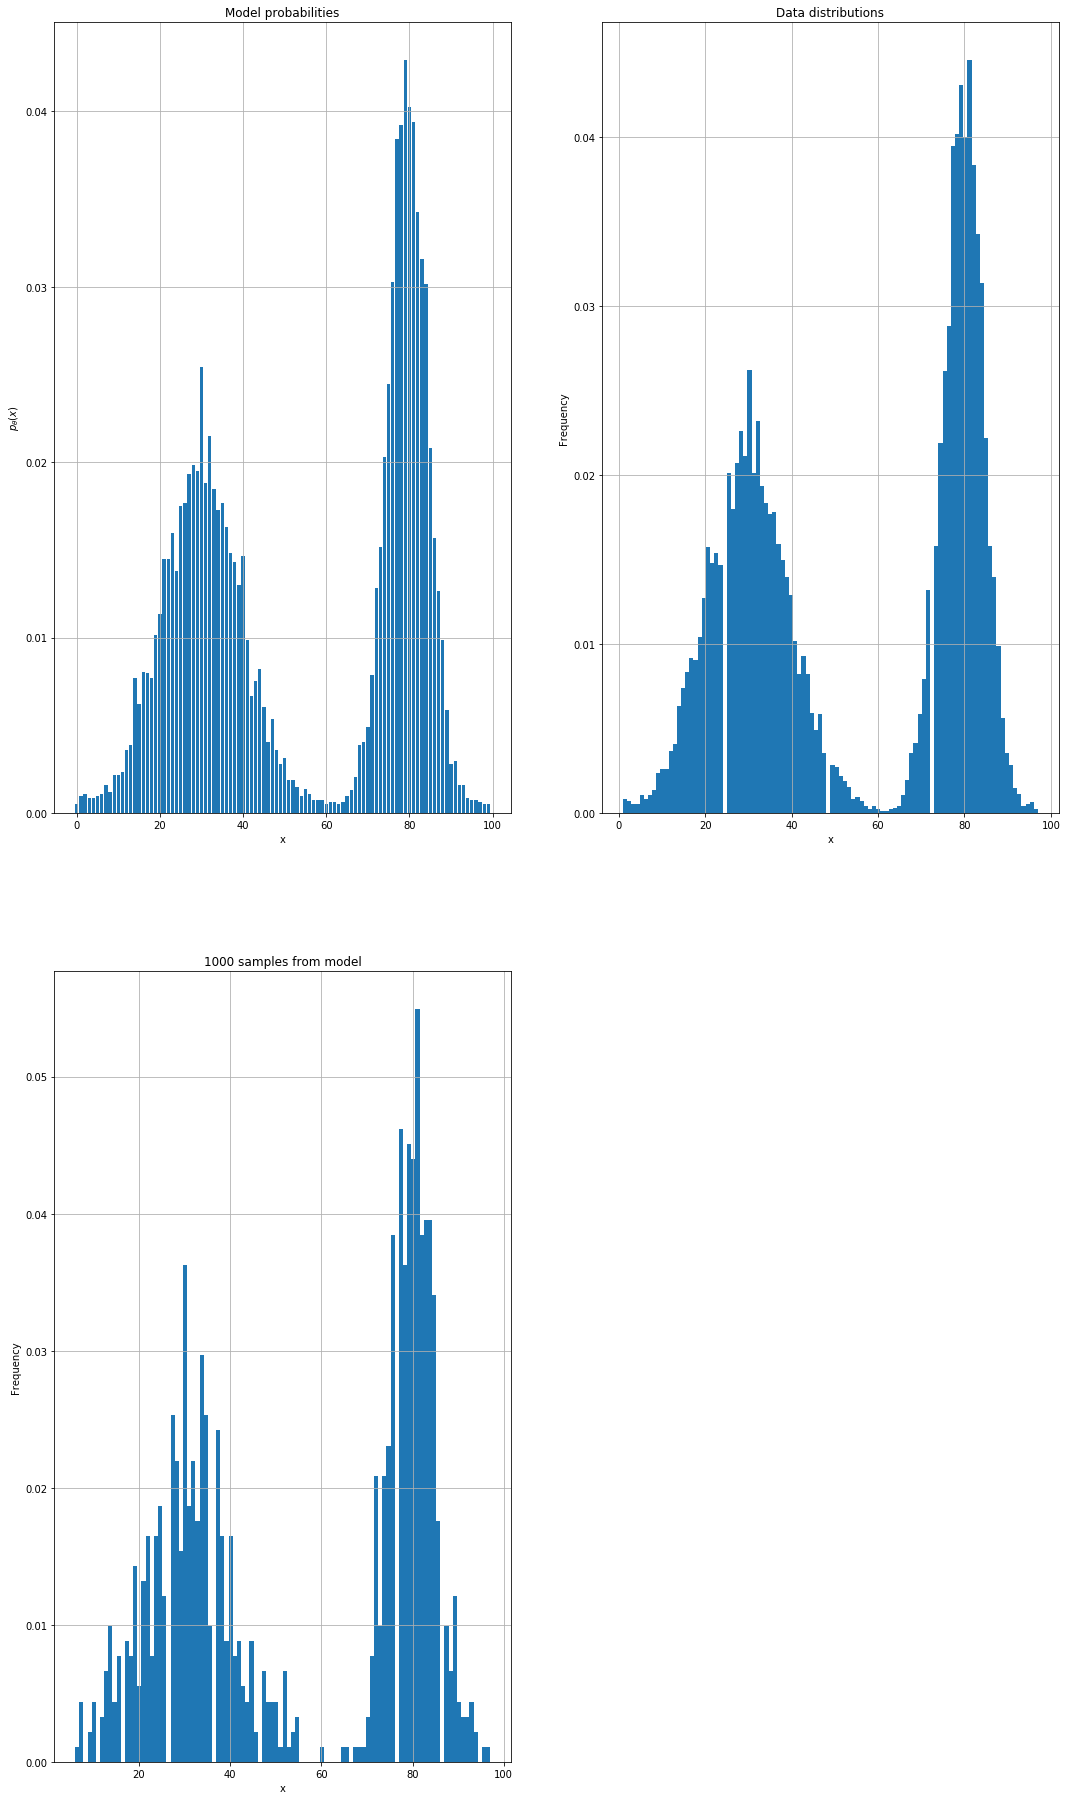

In [14]:
# Sampling after training
plt.figure(figsize=(18, 32))
plt.subplot(221)
plt.bar(np.arange(len(p)), p)
plt.title('Model probabilities')
plt.xlabel('x')
plt.ylabel('$p_{\\theta}(x)$')
plt.grid(True)

plt.subplot(222)
plt.hist(data, bins=100, density=True)
plt.title('Data distributions')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(223)
samples = np.random.choice(np.arange(100), p=p, size=1000)
plt.hist(samples, bins=100, density=True)
plt.title('1000 samples from model')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.grid(True)

## Exercise 2: Two-dimensional data

In [18]:
probs = np.load('distribution.npy')

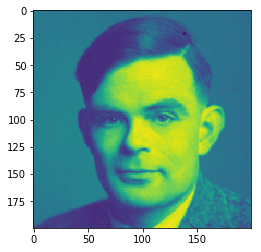

In [21]:
plt.imshow(probs)

In [23]:
samples = np.random.choice(np.arange(len(probs.ravel())), p=probs.ravel(), size=100000)
samples_x = samples % 200
samples_y = samples // 200
samples = np.stack([samples_x, samples_y], axis=1)
train = samples[0:int(0.8*len(samples))]
test = samples[int(0.8*len(samples)):]

In [24]:
import seaborn

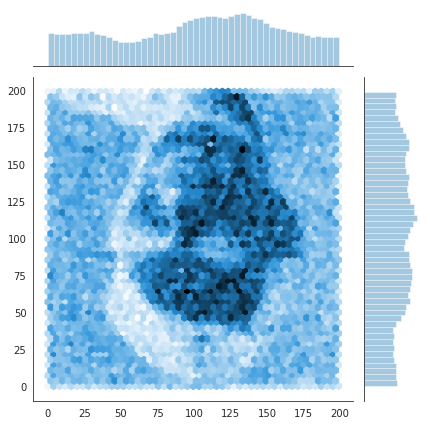

In [25]:
with seaborn.axes_style("white"):
    seaborn.jointplot(samples_x, samples_y, kind="hex")

In [26]:
batch_size=1000
n = 200
from torch.autograd import Variable
theta=torch.zeros(n, requires_grad=True)
epochs = 30

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc = nn.Linear(n,n)
        self.fc2= nn.Linear(n,n)
        self.theta = nn.Parameter(torch.zeros(n,requires_grad=True))
        
    def forward(self, x):
        onehot = F.one_hot(x[:,0].long(), num_classes=200)
        onehot = onehot.float()
        
        
        _theta=torch.exp(self.theta) / torch.sum(torch.exp(self.theta))
        prob = torch.gather(_theta,dim=0, index=x[:,0].long())

        prob2 = nn.functional.relu(self.fc(onehot))
        prob2 = nn.functional.relu(self.fc2(prob2))
        prob2 = nn.functional.softmax(prob2)
        
        prob2=torch.gather(prob2.T, dim=0, index=x[:,1].unsqueeze(0).long())

        return prob2, prob
    
    def loss(self, x):
        px2x1 ,px1 = self.forward(x)
        loss = -torch.sum(torch.log2(px1+1e-10) + torch.log2(px2x1+1e-10))/(2*px2x1.shape[1])
        
        return loss

net = MLP()


In [39]:
print(net)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0001)
for param in net.parameters():
    print(type(param.data), param.size())

MLP(
  (fc): Linear(in_features=200, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
)
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])


In [22]:
import warnings

warnings.filterwarnings('ignore')

Epoch 0: loss 7.55988073348999 val_loss 7.621488094329834 
Epoch 10: loss 7.561043739318848 val_loss 7.6232171058654785 
Epoch 20: loss 7.581075191497803 val_loss 7.624702453613281 


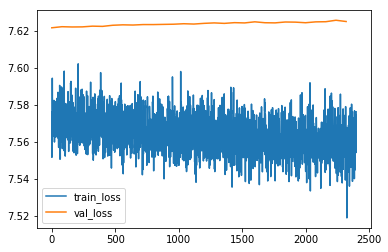

In [43]:
losses, val_losses =[],[]
train_iter = torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=test,batch_size=batch_size,shuffle=True)
losses = []
val_losses = []


for epoch in range(epochs):
    loss = 0

    for train_batch in train_iter:
        loss = net.loss(train_batch)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())
        del loss
        loss = 0
        
    with torch.set_grad_enabled(False):
        val_loss = net.loss(torch.from_numpy(test))
        val_losses.append(val_loss.data.numpy())
        
    if epoch % 10 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))

import matplotlib.pyplot as plt
plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()

In [49]:
p1, p2 = net.forward(torch.from_numpy(test))
p1 = p1.detach().numpy()
p2 = p2.detach().numpy()

In [50]:
theta = net.theta
p1_theta = torch.exp(theta)/torch.sum(torch.exp(theta))
p1_theta = p1_theta.detach().numpy()

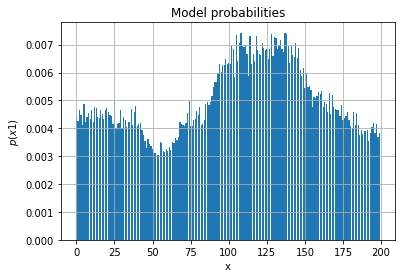

In [51]:
plt.bar(np.arange(len(p1_theta)), p1_theta)
plt.title('Model probabilities')
plt.xlabel('x')
plt.ylabel('$p_{}(x1)$')
plt.grid(True)

### Data distributions

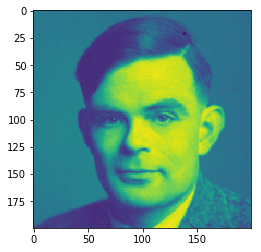

In [52]:
plt.imshow(probs)

### Sampling data

In [57]:
inp = [(x, y) for x in range(200) for y in range(200)]

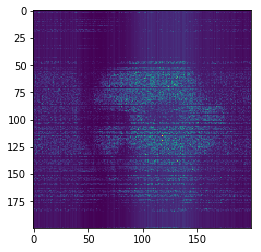

In [56]:
p_1,p_2=net.forward(torch.from_numpy(np.array(inp)))
sample_data = p_2*p_1 # The joint probabilities
sample_data = sample_data.reshape(200,200).T.detach().numpy()
plt.imshow(sample_data)

### MADE

The paper link is [MADE: Masked Autoencoder for Distribution Estimation](https://arxiv.org/abs/1502.03509 "With a title")

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
n = 200

### The masked linear connected

In [13]:
class MaskedLinear(nn.Linear):
    #Linear with mask
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

In [31]:
class MADE(nn.Module):
    def __init__(self, hidden_sizes, natural_ordering=False):
        
        super().__init__()
        self.hidden_sizes = hidden_sizes
        
        #Compute h0
        layers = [MaskedLinear(n,hidden_sizes[0])]
        
        layers = []
        #compute h^l for l=1..L
        for m in range(0,len(hidden_sizes)-1):
            layers.append(nn.ReLU())
            layers.append(MaskedLinear(hidden_sizes[m], hidden_sizes[m+1]))
        layers.append(nn.ReLU())
        layers.append(MaskedLinear(hidden_sizes[-1], n))
        #compute x_hat

        self.net = nn.Sequential(*layers)
        self.softmax = nn.Softmax()
        
        self.seed = 0 
        self.m = []
        self.make_masks()
        
    def make_masks(self):
        L = len(self.hidden_sizes)
        
        #rng = np.random.RandomState(self.seed)
        #self.seed = (self.seed + 1)
        
        np.random.seed(self.seed)
        self.seed = (self.seed + 1)
        
        #sampling m^l vectors
        self.m.append(np.random.randint(0,high=n,size=n))
        for l in range(L):
            self.m.append(np.random.randint(self.m[l].min(),high=n,size=self.hidden_sizes[l]))
        
        # construct masks
        masks = [self.m[l][:,None] <= self.m[l+1][None,:] for l in range(L)]
        masks.append(self.m[L][:,None] < self.m[0][None,:])
                
        
        # multiply the masks on each linear layer
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        onehot1 = F.one_hot(x[:,0].long(), num_classes=n).float()
        #print(F.one_hot(x, num_classes=n).float().reshape(-1,n*2)[0])
        #onehot = torch.cat((onehot1, onehot2), 1)
        out = self.net(onehot1)#.view(-1,2,n)
        sout=F.softmax(out)
        prob1 =torch.gather(sout.T, dim=0, index=x[:,0].unsqueeze(0).long())
        prob2 =torch.gather(sout.T, dim=0, index=x[:,1].unsqueeze(0).long())
        return prob2#prob1*prob2

    def loss(self, x):
        prob = self.forward(x)
        loss = -torch.sum(torch.log2(prob+1e-10))/(2*prob.shape[1])
        
        return loss
net = MADE([200,200])

In [34]:
print(net)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, weight_decay=0.0001)
for param in net.parameters():
    print(type(param.data), param.size())

MADE(
  (net): Sequential(
    (0): ReLU()
    (1): MaskedLinear(in_features=200, out_features=200, bias=True)
    (2): ReLU()
    (3): MaskedLinear(in_features=200, out_features=200, bias=True)
  )
  (softmax): Softmax(dim=None)
)
<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])


In [35]:
import warnings

warnings.filterwarnings('ignore')

Epoch 0: loss 3.791466474533081 val_loss 3.814868211746216 
Epoch 10: loss 3.779101610183716 val_loss 3.808861255645752 
Epoch 20: loss 3.7873082160949707 val_loss 3.8171513080596924 


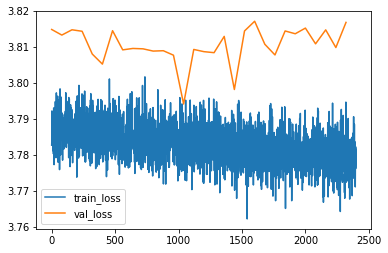

In [37]:
losses, val_losses =[],[]
train_iter = torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=test,batch_size=batch_size,shuffle=True)
losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0
    
    for train_batch in train_iter:
        loss = net.loss(train_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())
        
    with torch.set_grad_enabled(False):
        val_batch = next(iter(val_iter))
        val_loss = net.loss(val_batch)
        val_losses.append(val_loss.data.numpy())
        
    if epoch % 10 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))
        
import matplotlib.pyplot as plt
plt.plot(losses, label='train_loss')
plt.plot(np.arange(0, len(losses), int(len(losses)/len(val_losses))), val_losses, label='val_loss')
plt.legend()
plt.show()

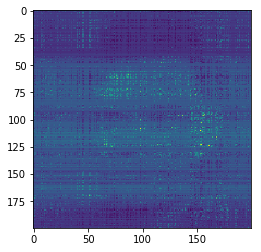

In [39]:
inp = [(x, y) for x in range(200) for y in range(200)]
prob = net.forward(torch.from_numpy(np.array(inp)))
prob = prob.reshape(200,200).T.detach().numpy()
plt.imshow(prob)

由上述两种方法可以看出，$MADE$的方法比只用$MLP$做基于贝叶斯推断的网络效果好，且训练速度快

## Exercise 3: High-dimensional data

In [1]:
import pickle
import torch.nn.functional as F
import torch.nn as nn

In [2]:
with open('mnist-hw1.pkl', 'rb') as f:
    data = pickle.load(f)
    
x_train = data['train'][:20000].astype('float32')
x_val = data['train'][20000:21000].astype('float32')

In [3]:
x_train[0].shape

(28, 28, 3)

In [4]:
x_train.shape

(20000, 28, 28, 3)

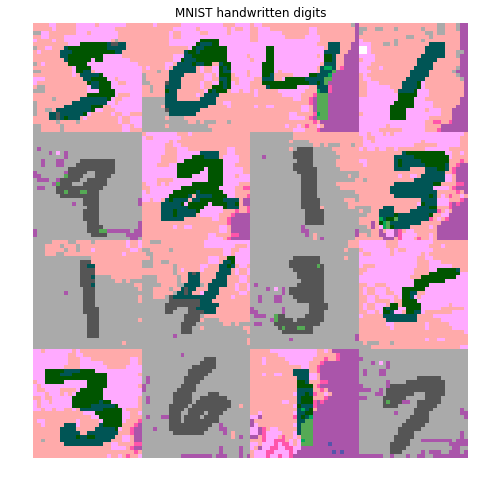

In [7]:
#plot a few MNIST examples
idx, dim, classes, rgb  = 0, 28, 4,3
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim ,rgb))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim, ] = x_train[idx]/rgb
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

In [8]:
x_train = torch.Tensor(x_train).permute(0, 3, 1, 2).cuda()
x_val = torch.Tensor(x_val).permute(0, 3, 1, 2).cuda()

In [9]:
x_train.shape

torch.Size([20000, 3, 28, 28])

### PixelCNN

In [10]:
import torch.nn as nn

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, channel_in, channel_out, kernel_size, stride, padding):
        super(MaskedConv2d, self).__init__(channel_in, channel_out, kernel_size, stride, padding, bias=False)
        self.mask_type = mask_type
        channel_out, channel_in, height, width = self.weight.size()

        mask = torch.ones(channel_out, channel_in, height, width)
        
        if mask_type == 'A':
            mask[:, :, height // 2, width // 2:] = 0
            mask[:, :, height // 2 + 1:] = 0
        else:
            mask[:, :, height // 2, width // 2 + 1:] = 0
            mask[:, :, height // 2 + 1] = 0
        
        #dont let self.mask appear in model.parameters() as it would then  be updated
        self.register_buffer('mask', mask)


    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [11]:
class MaskedLinear(nn.Linear):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedLinear, self).__init__(*args, **kwargs)
        
        # Two types of masking:
        # A) wiht colour1
        # B) with colour1 and colour2
        assert mask_type in {'1', '2'}
        
        self.register_buffer('mask', self.weight.data.clone())
        units_out, units_in = self.weight.size()

        # Making masking on half of the network
        self.mask.fill_(1)
        if (mask_type == '1'):
            self.mask[:units_out//2, units_in//2:] = 0

    def forward(self, x):
        # Apply masking
        self.weight.data *= self.mask
        return super(MaskedLinear, self).forward(x)
    

In [12]:
class ResNetBlock(nn.Module):
    def __init__(self,channels=128):

        super(ResNetBlock,self).__init__()
        self.channels=channels

        self.network = nn.Sequential(nn.ReLU(),
        nn.Conv2d(self.channels*2,self.channels, 1, stride=1, padding=0),nn.BatchNorm2d(self.channels), nn.ReLU(),
        MaskedConv2d('B',self.channels,self.channels, 3, stride=1, padding=1),nn.BatchNorm2d(self.channels), nn.ReLU(),
        nn.Conv2d(self.channels,self.channels*2, 1, stride=1, padding=0),nn.BatchNorm2d(2*self.channels)
        )

    def forward(self,x):
        out= self.network(x)
        return x+out
        

In [13]:
import torch.nn.functional as F
class PixelCNN(nn.Module):
    
    def __init__(self, num_layers=6,kernel=7,channels=64, final_channels=4):
        
        super(PixelCNN,self).__init__()
        self.num_layers = num_layers
        self.kernel = kernel
        self.channels = channels
        self.batch_size = 1
        self.final_channels = final_channels
        
        #PixelCNN layers
        self.layers=[MaskedConv2d('A',3,self.channels*2, self.kernel, stride=1, padding=3)]
        for m in range(0, self.num_layers):
            self.layers.append(ResNetBlock(self.channels))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(2*self.channels, 1024, 1, 1, 0))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(1024,rgb*final_channels, 1, 1, 0))
        
        self.network = nn.Sequential(*self.layers)

        
        # MADE layers:
        self.MADE = nn.Sequential(
            MaskedLinear('1', in_features=dim*dim*2*final_channels, out_features=256),
            nn.ReLU(),
            MaskedLinear('1', in_features=256, out_features=256),
            nn.ReLU(),
            MaskedLinear('1', in_features=256, out_features=dim*dim*2*final_channels)
        )
        
        

        
    def forward(self,x):
        self.batch_size = x.shape[0]
        x = self.network(x)
        x = x.view(self.batch_size, rgb, self.final_channels, dim, dim)
        
        # Find colour 1 and 1 & 2
        col_1 = x[:,0,:,:,:]
        col_2 = x[:,0:2,:,:,:]

        # Send colour 2 and 3 trough MADE FFNN
        col_2 = col_2.reshape(self.batch_size, -1)
        col_2 = self.MADE(col_2)
        col_2 = col_2.reshape(self.batch_size, self.final_channels,2, dim, dim)
        col_2 = col_2.permute(0,2,1,3,4)


        # [batch_size, channels, classes, height, width] 
        col_1 = col_1.unsqueeze(1)
        x = torch.cat((col_2, col_1), 1)
        x = x.reshape(self.batch_size, rgb,final_channels, dim, dim)
      
        # [batch_size, 28, 28, channels=3,classes=4]
        x = x.permute(0, 3, 4, 1, 2)
        F.softmax(x, dim=-1)
        return x
    
    

In [14]:
pikzelSeNN = PixelCNN().cuda()

In [15]:
optimizer = torch.optim.Adam(pikzelSeNN.parameters(), lr=3e-4, weight_decay=0.0001)

In [16]:
def recurrent_sampling(net):
    
    samples = torch.Tensor(np.random.choice(4, size=(1, 3, 28, 28))).type(torch.FloatTensor).cuda()
    for k in range(3):
        for i in range(28):
            for j in range(28):
                out = net(samples)
                intensity = torch.argmax(out, dim=-1).permute(0,3,1,2)
                samples[:,k, i, j] = intensity[:, k, i, j]
                
    samples = samples.cpu()
    samples = samples.permute(0,2,3,1)
    samples = samples.type(torch.FloatTensor)
    
    # plot a few MNST examples
    idx, dim, classes, rgb = 0, 28, 1, 3
    #create empty canvas
    canvas = np.empty((dim*classes, classes*dim, rgb))
    
    # fill with tensors
    for i in range(classes):
        for j in range(classes):
            canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim, ] = samples[idx]/rgb
            idx += 1
        
    # visualize matrix of tensors as gray scale image
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(canvas, cmap='gray')
    plt.title('Recurrent sampling')
    plt.show()

In [17]:
def naive_sampling(net):
    sample = torch.Tensor(np.random.choice(4, size=(1, 3, 28, 28))).type(torch.FloatTensor).cuda()
    out = net(sample)
    sample = torch.argmax(out, dim=4)
    
    sample = sample.cpu()
    sample = sample.reshape(1,28,28,3)
    sample = sample.type(torch.FloatTensor)
    
    # plot a few MNST examples
    idx, dim, classes, rgb = 0, 28, 1, 3
    #create canvas
    canvas = np.empty((dim*classes, dim*classes, rgb))
    
    #fill with tensors
    for i in range(classes):
        for j in range(classes):
            canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = sample[idx]/rgb
            idx += 1
            
    # visualize matrix of tensors as gray scale image
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(canvas, cmap='gray')
    plt.title('Naive sampling')
    plt.show()

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
batch_size = 200
epochs = 50

In [20]:
losses, val_losses =[],[]
train_iter = torch.utils.data.DataLoader(dataset=x_train,batch_size=batch_size,shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=x_val,batch_size=len(x_val),shuffle=True)
losses = []
val_losses = []

In [ ]:
for epoch in range(epochs):
    train_loss = 0
    
    pikzelSeNN.train()
    for train_batch in train_iter:
        x_batch = train_batch.view(-1).type(torch.cuda.LongTensor)
        output = pikzelSeNN.forward(train_batch).cuda().contiguous().view(-1,4)
        
        loss = criterion(output, x_batch)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.cpu().numpy())
    
    pikzelSeNN.eval()
    with torch.set_grad_enabled(False):
        val_batch = next(iter(val_iter))
        
        x_batch = val_batch.view(-1).type(torch.cuda.LongTensor)
        output = pikzelSeNN.forward(val_batch).cuda()
        output = output.contiguous().view(-1,4)
        
        val_loss = criterion(output, x_batch)
        val_losses.append(val_loss.data.cpu().numpy())
       
    if epoch % 1 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))
        
        # Samples
    if (epoch) % 10 == 0:
      naive_sampling(pikzelSeNN)
      
      recurrent_sampling(pikzelSeNN)
      

import matplotlib.pyplot as plt
plt.figure()
plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()